In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow.compat.v1 as tf1
tf1.compat.v1.enable_eager_execution()

In [3]:
import sys
sys.path.append('../code/')
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow import keras

import utils
from data_loading import ImageSequence

from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input

In [4]:
tf.get_logger().setLevel('INFO')

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### adversarial loop

In [6]:
# EPS = 5 / 255.0
# LR = 0.05
# optimizer = Adam(learning_rate=LR)
# lossfn = CategoricalCrossentropy()

# def clip_eps(tensor, eps):
#     # clip the values of the tensor to a given range and return it
#     return tf.clip_by_value(tensor, clip_value_min=-eps,
#         clip_value_max=eps)

# def generate_adversaries(model, baseImage, delta, classIdx, steps=50, verbose=False):
#     ty = np.zeros(1001)
#     ty[classIdx] = 1
#     ty = np.expand_dims(ty, axis=0)
#     for step in range(0, steps):
#         with tf.GradientTape() as tape:
#             tape.watch(delta)
#             adversary = baseImage + preprocess_input(delta)
#             predictions = model(adversary, training=False)
#             loss = lossfn(tf.convert_to_tensor(ty), predictions)                        
#             if verbose and step % 10 == 0:
#                 print("step: {}, loss: {}...".format(step,
#                     loss.numpy()))
#         # calculate the gradients of loss with respect to the perturbation vector
#         gradients = tape.gradient(loss, delta)
#         # update the weights, clip the perturbation vector, and
#         # update its value
#         optimizer.apply_gradients([(gradients, delta)])
#         delta.assign_add(clip_eps(delta, eps=EPS))
#     return delta            

## Load samples

In [7]:
dataset_path = '/data/datasets/imagenet2012/'

In [8]:
train_generator = ImageSequence(dataset_path, 80, target_split='train', square_ims='center_pad', augment=True)

  1%|          | 12/1001 [00:00<00:08, 118.32it/s]

generating splits


100%|██████████| 1001/1001 [00:09<00:00, 105.05it/s]


In [9]:
new_model = keras.models.load_model('./resnet_1001_10_iters.hdf5')

In [10]:
s = train_generator.get_random_sample('test', cat=1000)
proc_s = train_generator.load_im_and_proc(s[1])
s
s[1] = '/home/ivan/Dropbox/scratch/brad_targets/aa.jpeg'

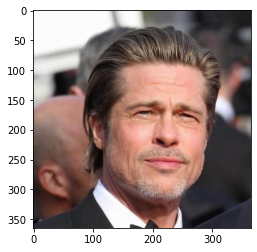

In [11]:
plt.figure()
plt.imshow(plt.imread(s[1]))

In [12]:
pp = new_model.predict(proc_s)
np.argmax(pp[0]), np.max(pp[0]), pp[0][1000]

(1000, 0.995889, 0.995889)

In [12]:
class_desc_mapper = train_generator.generate_classes_and_desc()

In [13]:
# from PIL import Image

In [14]:
# i_path = '/home/ivan/scratch/marmot.jpg'
# i_path = s[1]
# im_pil_raw_squared = utils.center_crop_square(i_path, desired_size=224)
# im_ar =  np.asarray(im_pil_raw_squared).copy()
# im_ar_proc = preprocess_input(np.expand_dims(im_ar.copy(), axis=0))[0]
im_ar = plt.imread(s[1])
im_ar_proc = train_generator.load_im_and_proc(s[1])
im_ar_proc_single = im_ar_proc[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


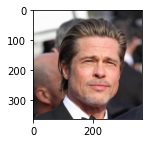

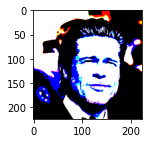

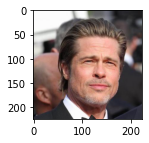

In [15]:
plt.figure(figsize=(2,2))
plt.imshow(im_ar)
plt.figure(figsize=(2,2))
plt.imshow(im_ar_proc_single)
plt.figure(figsize=(2,2))
plt.imshow(utils.depreprocess(im_ar_proc_single)/255)

In [16]:
from l2_attack import CarliniL2

Instructions for updating:
non-resource variables are not supported in the long term


In [17]:
del new_model

In [18]:
sess = tf.compat.v1.Session()

init_g = tf1.global_variables_initializer()
init_l = tf1.local_variables_initializer()

with sess.as_default():
    
    new_model = keras.models.load_model('./resnet_1001_10_iters.hdf5')
    sess.run(init_g)
    sess.run(init_l)
    assert tf.compat.v1.get_default_session() is sess
    attacker = CarliniL2(sess,
                        new_model,
                         image_size=224,
                         num_channels=3,
                         num_labels=1001,
                    )
# sess.close()

/home/ivan/coding_projects/ThisIsNotBradPitt/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


FailedPreconditionError: 2 root error(s) found.
  (0) Failed precondition: Attempting to use uninitialized value Variable
	 [[{{node Variable/read}}]]
	 [[predictions1001/Softmax/_1971]]
  (1) Failed precondition: Attempting to use uninitialized value Variable
	 [[{{node Variable/read}}]]
0 successful operations.
0 derived errors ignored.

In [22]:
1

1

In [16]:
# # ii = image.load_img(i_path, target_size=(224, 224))
# # ii = image.load_img(i_path, target_size=(224, 224))
# im_ar =  image.img_to_array(im_pil_raw_squared).copy()
# im_proc = preprocess_input(np.expand_dims(im_ar.copy(), axis=0))

baseImage = tf.constant(im_ar_proc, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)
deltaUpdated = generate_adversaries(new_model, baseImage, delta, 245, steps=200, verbose=True)

adverImage = (baseImage + deltaUpdated).numpy().squeeze()
adverImage = np.clip(adverImage, 0, 255).astype("uint8")

step: 0, loss: 20.228601455688477...
step: 10, loss: 4.569601058959961...
step: 20, loss: 0.07405577600002289...
step: 30, loss: 0.008246419951319695...
step: 40, loss: 0.005725413095206022...
step: 50, loss: 0.0060854386538267136...
step: 60, loss: 0.006579166743904352...
step: 70, loss: 0.006326173432171345...
step: 80, loss: 0.0059351869858801365...
step: 90, loss: 0.0051854876801371574...
step: 100, loss: 0.004515213891863823...
step: 110, loss: 0.004102980252355337...
step: 120, loss: 0.0036532822996377945...
step: 130, loss: 0.0034143980592489243...
step: 140, loss: 0.0036676537711173296...
step: 150, loss: 0.00392618915066123...
step: 160, loss: 0.003783213207498193...
step: 170, loss: 0.0035497054923325777...
step: 180, loss: 0.00343542592599988...
step: 190, loss: 0.003382320748642087...


W Bradley Pitt, aka Brad 1000 0.9998629
bow_tie 457 9.300595e-05
suit 834 2.6937158e-05


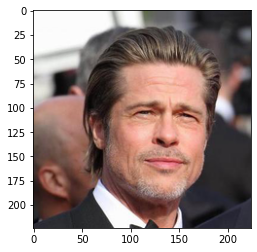

______________
ballpoint 418 0.24659751
wallet 893 0.17956619
American_coot 137 0.16083784


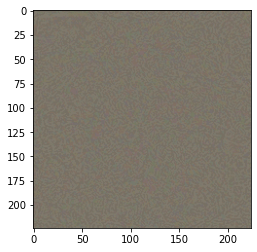

______________
W Bradley Pitt, aka Brad 1000 0.9998629
bow_tie 457 9.300595e-05
suit 834 2.6937158e-05


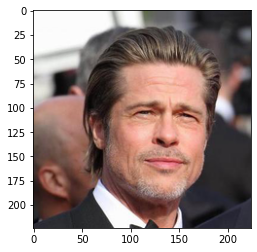

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
bow_tie 457 0.92955846
W Bradley Pitt, aka Brad 1000 0.032627255
French_bulldog 245 0.008656731


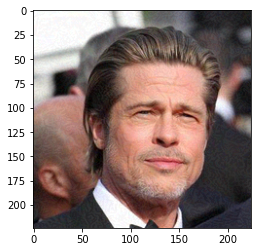

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
bow_tie 457 0.5508727
beagle 162 0.16982731
vizsla 211 0.03983596


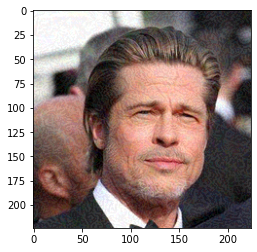

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
bow_tie 457 0.22320808
jigsaw_puzzle 611 0.19287302
Chihuahua 151 0.12554796


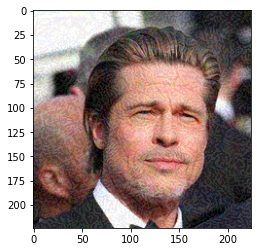

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.40146193
eel 390 0.25959417
chain_mail 490 0.09270956


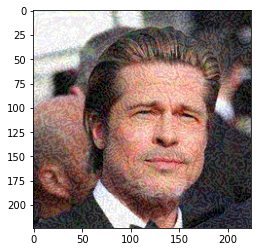

______________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eel 390 0.5720717
jigsaw_puzzle 611 0.29272556
chain_mail 490 0.06656832


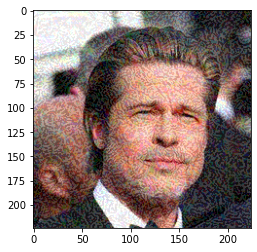

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
eel 390 0.41847277
jigsaw_puzzle 611 0.2974942
loupe 633 0.18466058


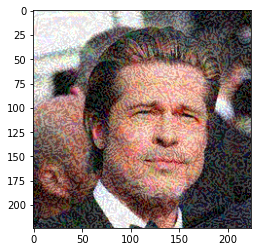

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.49692908
loupe 633 0.30154994
eel 390 0.14802201


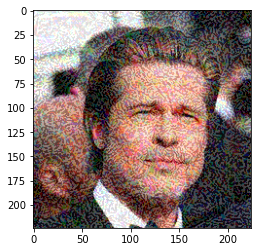

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.504516
loupe 633 0.36291134
eel 390 0.11378723


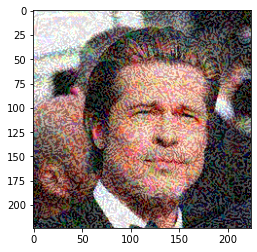

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.7381111
loupe 633 0.1389581
eel 390 0.11726916


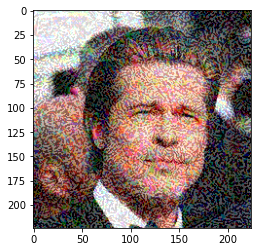

______________


In [18]:
ims_test = [baseImage, deltaUpdated]
for i in range(10):
    ims_test.append(baseImage + i* deltaUpdated)

ims_test = np.concatenate(ims_test,axis=0)
preds_all = new_model.predict(ims_test)

for ii, p in zip(ims_test, preds_all):
    top_args = p.argsort()[-3:][::-1]
    plt.figure()
    plt.imshow(np.round(utils.depreprocess(ii)).astype('int32'))
    for ta in top_args:
        print(class_desc_mapper[ta], ta, p[ta])
    plt.show()
    print('______________')

### Brute force loop

In [1]:
# # im_ar =  image.img_to_array(im_pil_raw_squared).copy()
# # # im_proc = preprocess_input(np.expand_dims(im_ar.copy(), axis=0))
# # im_ar_proc

# noise_strengs = np.arange(10) / 2
# # iterate over different noise categories
# outputs = []
# for noise_cat in tqdm(np.random.choice(np.arange(1000), 4, replace=True)):

#     baseImage = tf.constant(im_ar_proc, dtype=tf.float32)
#     delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)
#     deltaUpdated = generate_adversaries(new_model, baseImage, delta, noise_cat, steps=500, verbose=False)

# #     adverImage = (baseImage + deltaUpdated).numpy().squeeze()
# #     adverImage = np.clip(adverImage, 0, 255).astype("uint8")

#     ims_test = np.concatenate([baseImage + ns * deltaUpdated for ns in noise_strengs], axis=0)
#     preds_all = new_model.predict(ims_test)
# #     preds_decoded = utils.decode_predictions(preds_all, top=3)
#     for ii, p in zip(ims_test, preds_all):
#         top_args = p.argsort()[-3:][::-1]
#         top_desc = [class_desc_mapper[ta] for ta in top_args]
#         plt.figure()
#         plt.imshow(np.round(utils.depreprocess(ii)).astype('int32'))
#         for ta in top_args:
#             print(class_desc_mapper[ta], ta, p[ta])
#         plt.show()
#         print('______________')
    
#     for ns, pred in zip(noise_strengs, top_desc):
#         sample = [s[1], noise_cat, ns, pred]
#         outputs.append(sample)
        
            